In [21]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from scipy.integrate import quad
import scipy.stats as stats

In [163]:
# Definición de variables eV

k = 8.617333262e-5 # eV / K
h = 4.135667e-15 # eV*s
h_bar = h/(2*np.pi) # eV*s
m =  0.5*510999 #eV/c^2  #0.5*9.1e-31 # kg
# m =  0.5*8.19e-12
# m = 0.5*9.1e-31
q = 1.602176e-19 # C

Ec = -4.7  #eV
Ef = -5.0 #eV

L = 40e-9 # m
W = 3*L # m

C_g = 0.1e-15*q # Faradio = Q/V = Q^2/eV
C_q = q*q*m*W*L/(2*np.pi*h_bar*h_bar) # Q^2/eV

C_es = C_g+C_q

eta = C_g/C_es
V_t = Ec

# Parte I

In [192]:
# Funciones de integrales
def int_N(E,U,T,Vds):
    # print(E, (U+Ec)/(k*T))
    if E < Ef/(k*T):
        return 1/np.sqrt(E-(U+Ec)/(k*T))*(1/(1+np.exp(E-Ef/(k*T)))+1/(1+np.exp(E-(Ef-Vds)/(k*T))))
    else:
        return 1/np.sqrt(E-(U+Ec)/(k*T))*(np.exp(Ef/(k*T)-E)/(1+np.exp(Ef/(k*T)-E)) + np.exp((Ef-Vds)/(k*T)-E)/(1+np.exp((Ef-Vds)/(k*T)-E)))

def int_I(E,U,T, Vds):
    if E < Ef/(k*T):
        return np.sqrt(E-(U+Ec)/(k*T))*(1/(1+np.exp(E-Ef/(k*T)))-1/(1+np.exp(E-(Ef-Vds)/(k*T))))
    else:
        return np.sqrt(E-(U+Ec)/(k*T))*(np.exp(Ef/(k*T)-E)/(1+np.exp(Ef/(k*T)-E)) - np.exp((Ef-Vds)/(k*T)-E)/(1+np.exp((Ef-Vds)/(k*T)-E)))

# Funciones de cálculo
def get_N(U,T, Vds):
    cte = L*np.sqrt(k*T)*np.sqrt(2*m)/h
    integral = quad(int_N,
                    (U+Ec)/(k*T),
                    np.inf, 
                    args=(U, T, Vds))
    # print(cte, integral) 
    return cte*integral[0]

def get_U(N,N_0, V_gs):
    return q*q/C_es*(N-N_0)-V_gs*eta

def get_I(U, T, Vds):
    cte = q*W*4*np.sqrt(2*m*k*T)*k*T/(h*h)
    integral = quad(int_I,
                    (U+Ec)/(k*T),
                    np.inf, 
                    args=(U, T, Vds))
    return cte*integral[0]

# Loop de autoconsistencia
def solve_I(Vds,T,Vgs, U_ = -1, tol = 1e-4,lr = 1e-3):
    

    N_0 = get_N(-Vgs*eta, T, 0)
    print(f"N_0 = {N_0}")
    # U_ = -1
    
    for _ in tqdm(range(int(1e4)), disable=False):
        N = get_N(U_,T, Vds)
        # print(f"N = {N}")
        U = get_U(N,N_0,Vgs)

        if abs(U-U_) < tol:
            # print('a')
            break

        else:
            U_ = U_ +lr*(U-U_)
    
    I = get_I(U,T,Vds)
    return U, I


In [197]:
U,I = solve_I(Vds = 0.25, 
        T = 1, 
        Vgs = 0.5, 
        lr = 0.01)
print(U,I*1e6)

N_0 = 0.0


  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\diego\AppData\Local\Temp\ipykernel_22168\581724217.py:5: RuntimeWarning: overflow encountered in exp
  return 1/np.sqrt(E-(U+Ec)/(k*T))*(1/(1+np.exp(E-Ef/(k*T)))+1/(1+np.exp(E-(Ef-Vds)/(k*T))))
C:\Users\diego\AppData\Local\Temp\ipykernel_22168\581724217.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral = quad(int_N,
  8%|▊         | 848/10000 [00:07<01:24, 108.79it/s]

-0.4999999999862704 191656782588.66547



C:\Users\diego\AppData\Local\Temp\ipykernel_22168\581724217.py:11: RuntimeWarning: overflow encountered in exp
  return np.sqrt(E-(U+Ec)/(k*T))*(1/(1+np.exp(E-Ef/(k*T)))-1/(1+np.exp(E-(Ef-Vds)/(k*T))))


In [187]:
def plot_IVds(T,Vgs, tol = 1e-4,lr = 1e-2):
    Vds_array = np.arange(0, 0.5, 0.01)

    Ids_array = []

    U = -1

    for i, Vds in enumerate(Vds_array):
        U, I = solve_I(
            Vds = Vds,
            T = T,
            Vgs = Vgs,
            U_ = U,
            lr = lr
        )
        Ids_array.append(I)

        if i % 10 == 0:
            print(i)

    plt.plot(Vds_array, np.array(Ids_array)*1e6)

    return Vds_array, Ids_array

N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]

  8%|▊         | 848/10000 [00:02<00:25, 356.59it/s]


0
N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


10
N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


20
N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]

N_0 = 33152.71697890423

  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


30
N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


40
N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]

N_0 = 33152.71697890423



  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


N_0 = 33152.71697890423


  0%|          | 0/10000 [00:00<?, ?it/s]


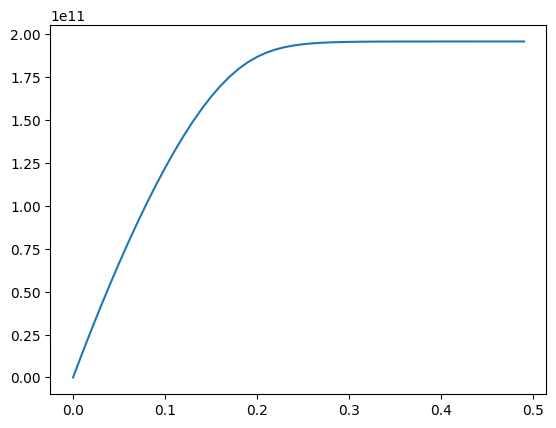

In [194]:
Vds_array, Ids_array = plot_IVds(
    T = 298,
    Vgs = 0.5
)

# Parte II

In [113]:
def I_lineal(Vds, V_gs): # eq 5.60
    cnt = q*W/(h_bar*h_bar*np.pi*np.pi)*np.sqrt(8*m/9)*np.sqrt(q*eta)**3
    # print(np.sqrt(V_gs-V_t-Vds/eta)**3, np.sqrt(V_gs-V_t)**3, cnt, cnt*(np.sqrt(V_gs-V_t)**3-np.sqrt(V_gs-V_t-Vds/eta)**3))
    return cnt*(np.sqrt(V_gs-V_t)**3-np.sqrt(V_gs-V_t-Vds/eta)**3)


def I_saturado(V_gs): # eq 5.61
    cnt =  q*W/(h_bar*h_bar*np.pi*np.pi)*np.sqrt(8*m/9)*np.sqrt(q*eta)**3
    return cnt*np.sqrt(V_gs-V_t)**3


I_lineal = np.vectorize(I_lineal)
I_saturado = np.vectorize(I_saturado)


In [114]:
np.sqrt(0.5-V_t)**3-np.sqrt(0.5-V_t-0.05/eta)**3

0.17061453158351192

In [115]:
q*W/(h_bar*h_bar*np.pi*np.pi)*np.sqrt(8*m/9)*np.sqrt(q*eta)**3

5.501439722216893e-31

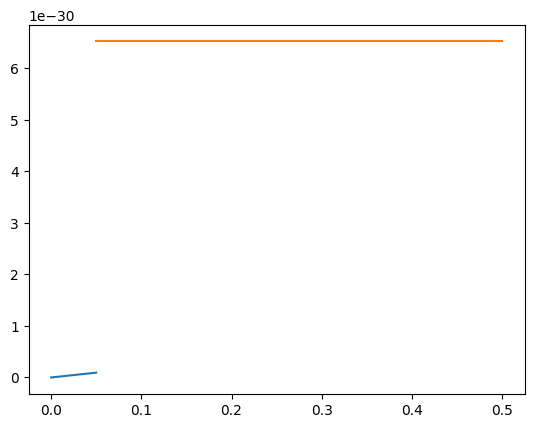

In [116]:
x = np.linspace(0,0.05, 10)
x_ = np.linspace(0.05,0.5,10)

V_gs = 0.5
V_gs_ = np.ones(10)*V_gs

y = I_lineal(x, V_gs)
y_ = I_saturado(V_gs_)

plt.plot(x,y)
plt.plot(x_,y_)

In [28]:
eta

0.8963395609456556